# Imports

In [1]:
from IPython.display import Audio, display

from itertools import groupby
import itertools
flatten = itertools.chain.from_iterable
from math import ceil
from pathlib import Path
import datetime
import json
import collections
from timeit import default_timer as timer
import os

from resemblyzer import preprocess_wav, VoiceEncoder
import matplotlib.pyplot as plt
import librosa
import librosa.display
import matplotlib
from matplotlib import style
import numpy as np
from numpy import linalg as LA
import sounddevice as sd
import webrtcvad
from pyannote.core import Segment, Timeline, Annotation, notebook
from pyannote.metrics.diarization import DiarizationErrorRate, GreedyDiarizationErrorRate, JaccardErrorRate
import scipy
from scipy.sparse import csgraph
from scipy.spatial.distance import pdist, squareform, euclidean, cosine
import scipy.signal as sps
import pydub
from webrtcvad_wrapper import VAD
import pydub.scipy_effects
from pydub import AudioSegment
import soundfile as sf

AudioSegment.converter = '/usr/local/Cellar/ffmpeg/4.2.2_2/bin/ffmpeg'

# Constants and functions definitions

In [2]:
## Plots preparation

style.use('seaborn')

color = {
    -1: "black",
    0: "red",
    1: "orange",
    2: "blue",
    3: "brown",
    4: "purple",
    5: "plum",
    6: "gray",
    7: "khaki",
    8: "magenta",
    9: "cyan",
    10: "lime",
    11: "indigo",
    12: "royalblue",
    13: "dodgerblue",
    14: "lightcoral"
}

def timeTicks(x, pos):
    d = datetime.timedelta(seconds=x)
    return str(d)[-5:] if x < 3600 else str(d)
formatter = matplotlib.ticker.FuncFormatter(timeTicks)

In [3]:
def get_vad_segments(audio_segment):
    filtered_segments = vad.filter(audio_segment)

    return [
        (filtered_segment[0], filtered_segment[1])
        for filtered_segment in filtered_segments if filtered_segment[-1]
    ]

def remove_overlap(ranges):
    result = []
    current_start = -1
    current_stop = -1 

    for start, stop in sorted(ranges):
        if start > current_stop:
            # this segment starts after the last segment stops
            # just add a new segment
            result.append( (start, stop) )
            current_start, current_stop = start, stop
        else:
            # segments overlap, replace
            result[-1] = (current_start, stop)
            # current_start already guaranteed to be lower
            current_stop = max(current_stop, stop)

    return result

In [4]:
def plot_original_audio(speaker_segments):
    # display(Audio(wav, rate=source_sr))

    fig = plt.figure(figsize=(13, 3))
    axes = plt.axes()
    plt.title('Original audio')
    librosa.display.waveplot(original_audio * 2, sr=source_sr, color='lightgray')

    for line in speaker_segments:
        plt.plot(
            [x[line['start']], x[line['end']]],
            ['Speaker ' + str(line['speaker_id']), 'Speaker ' + str(line['speaker_id'])],
            color=color[line['speaker_id'] % 15],
            linewidth=3
        )

    if SHOW_SPEAKER_SWITCHES:
        for xc in speaker_switches:
            plt.axvline(x=xc, linewidth=.5)

    axes.xaxis.set_major_formatter(formatter)
    ticks_freq = ceil(len(wav) * .1 / source_sr)
    axes.xaxis.set_major_locator(plt.MultipleLocator(ticks_freq))

    plt.margins(x=0.01)
    plt.tight_layout()

In [5]:
def plot_ground_truth():
    fig = plt.figure(figsize=(13, 3))
    axes = plt.axes()
    plt.title('Ground truth')
    librosa.display.waveplot(original_audio * 2, sr=source_sr, color='lightgray')

    for item in ami_corpus_transcripts:
        id = item['speaker_id']
        plt.plot(
            [item['start'], item['end']],
            ['Speaker ' + str(id), 'Speaker ' + str(id)],
            color=color[id % 15],
            linewidth=4
        )

    if SHOW_SPEAKER_SWITCHES:
        for xc in speaker_switches:
            plt.axvline(x=xc, linewidth=.5)

    axes.xaxis.set_major_formatter(formatter)
    ticks_freq = ceil(len(original_audio) * .1 / source_sr)
    axes.xaxis.set_major_locator(plt.MultipleLocator(ticks_freq))

    plt.margins(x=0.01)
    plt.tight_layout()

In [6]:
def get_speaker_segments(labels_list):
    N = np.array(labels_list)
    counter = np.arange(1, np.alen(N))
    groupings = np.split(N, counter[N[1:] != N[:-1]])

    segments = []
    start = 0
    for group in groupings:
        if len(group) > 0 and group[0] is not None:
            segments.append({
                'start': start,
                'end': start + len(group) - 1,
                'speaker_id': group[0]
            })
        start += len(group)
    
    return segments

In [7]:
def get_similarity(embed_i, embed_j):
    return cosine(embed_i, embed_j)

In [8]:
def get_hypothesis(speaker_segments):
    hypothesis = Annotation()
    for t in speaker_segments:
        try:
            hypothesis[Segment(x[t['start']], x[t['end']])] = str(t['speaker_id']) + '_hyp'
        except:
            pass
        
    return hypothesis

der = DiarizationErrorRate()
gder = GreedyDiarizationErrorRate()
jer = JaccardErrorRate()

def measure_metrics(reference, hypothesis):
    der_value = der(reference, hypothesis)
    print('DER:', der_value)
    # print(der.report())

    ## Gives no difference with DER
    # print('GDER:', gder(reference, hypothesis))
    # print(gder.report())

    print('JER:', jer(reference, hypothesis))
    # print(jer.report())
    
    return der_value

In [9]:
def plot_der(hypothesis):
    fig = plt.figure(figsize=(13, 5))

    # plot hypothesis
    ax = plt.subplot(211)
    plt.title('hypothesis')
    ax.xaxis.set_major_formatter(formatter)
    ticks_freq = ceil(len(original_audio) * .1 / source_sr)

    notebook.plot_annotation(hypothesis, legend=True, time=True)
    librosa.display.waveplot(original_audio, sr=source_sr, color='lightgray')

    # plot reference
    ax = plt.subplot(212)
    plt.title('reference')
    ax.xaxis.set_major_formatter(formatter)

    notebook.plot_annotation(reference, legend=True, time=True)
    librosa.display.waveplot(original_audio, sr=source_sr, color='lightgray')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

In [10]:
# SOURCE_FOLDER = 'ami_corpus'
# SOURCE_FILE = 'ES2002a.Mix-Headset.wav'
# TRANSCRIPTS = f'{SOURCE_FOLDER}/transcripts.json'
# N_SPEAKERS = 4

SOURCE_FOLDER = 'records'
SOURCE_FILE = 'Pumpkin_and_Honey_Bunny.wav'
TRANSCRIPTS = f'{SOURCE_FOLDER}/transcripts.json'
N_SPEAKERS = 3

FILEPATH = str(Path(SOURCE_FOLDER, SOURCE_FILE))
SR = 32000

CHUNKS_FOLDER = 'chunks'

CUT_AUDIO = True
CUT_LENGTH = 10. * 60. # seconds

# Audio file loading

In [11]:
## Load audio

if CUT_AUDIO:
    wav, source_sr = librosa.load(FILEPATH, sr=SR, offset=0.0, duration=CUT_LENGTH)
else:
    wav, source_sr = librosa.load(FILEPATH, sr=SR)

original_audio = wav
print(len(wav))

3965361


# Loading transcripts

In [12]:
## Load transcripts from prepared file and mark reference annotations

with open(TRANSCRIPTS, 'r') as f:
    ami_corpus_transcripts = json.load(f)
    
SHOW_SPEAKER_SWITCHES = False    

if SHOW_SPEAKER_SWITCHES:
    if CUT_AUDIO:
        speaker_switches = [t['start'] for i, t in enumerate(ami_corpus_transcripts) \
            if i > 0 \
                and t['speaker_id'] != ami_corpus_transcripts[i - 1]['speaker_id'] \
                and t['end'] < CUT_LENGTH
        ]
    else:
        speaker_switches = [t['start'] for i, t in enumerate(ami_corpus_transcripts) \
            if i > 0 \
                and t['speaker_id'] != ami_corpus_transcripts[i - 1]['speaker_id']
        ]
    
    speaker_switches.insert(0, ami_corpus_transcripts[0]['start'])
    
if CUT_AUDIO and CUT_LENGTH < len(wav):
    ami_corpus_transcripts = [t for t in ami_corpus_transcripts if t['start'] < CUT_LENGTH]
    
reference = Annotation()
for t in ami_corpus_transcripts:
    try:
        reference[Segment(t['start'], t['end'])] = str(t['speaker_id']) + '_ref'
    except:
        pass

In [13]:
# Prepare everything for clustering

In [14]:
timers = []

x = librosa.times_like(len(wav), sr=SR, hop_length=1)

In [15]:
## Load voice encoder

encoder = VoiceEncoder()

Loaded the voice encoder model on cpu in 0.01 seconds.


In [17]:
CHUNK_TIME_LENGTH = 2.5 # seconds
CHUNKS_OVERLAP = .15 # share (percents)
SPEAKER_CHANGE_THRESHOLD = .3  # percents
SENSITIVITY_MODE = 2 # 4 is supposed to be better for neural networks, but it's not
FILTER_VALUE = 300

In [18]:
## Define Voice Activity Detector

vad = VAD(sensitivity_mode=SENSITIVITY_MODE)

In [19]:
## Clean chunks folder

filelist = [f for f in os.listdir(CHUNKS_FOLDER)]
for f in filelist:
    os.remove(os.path.join(CHUNKS_FOLDER, f))

chunk_size = ceil(CHUNK_TIME_LENGTH * SR)

embeds = []
speakers_ids = [0]
speaker_segments = []
vad_segments = []

counter = 0

# Chunks processing

In [21]:
## Process overlapping chunks
for i in range(0, len(wav), ceil(chunk_size * (1 - CHUNKS_OVERLAP))):
    t_start = timer()

    start = i
    end = i + chunk_size if i + chunk_size < len(wav) - 1 else len(wav) - 1
    
    chunk = wav[start:end]
    chunk = preprocess_wav(chunk)[0]

    if (len(chunk) > 0):
        filename = f'chunks/chunk_{i}.wav'
        sf.write(filename, chunk, samplerate=SR)
        audio = AudioSegment.from_file(filename)

        if audio.sample_width != 2:
            audio = audio.set_sample_width(2)
        if audio.channels != 1:
            audio = audio.set_channels(1)

        ## Apply 3rd order high pass filter with given value
        audio = audio.high_pass_filter(FILTER_VALUE, order=3)

        segments = get_vad_segments(audio)

        vad_segments += [(start + ceil(segment[0] * SR), start + ceil(segment[1] * SR)) for segment in segments]

        segments = [s for s in remove_overlap(vad_segments) if s[1] - s[0] > .2 * SR]
        segments = [(s[0] - start, s[1] - start) for s in segments if s[0] >= start]

        for segment in segments:
            seg_start, seg_end = segment
            frame = chunk[seg_start:seg_end]
            embed = encoder.embed_utterance(frame)

            if len(embeds) > 0:
                distances = []
                for speaker_id, speaker_embeddings in groupby(sorted(embeds, key=lambda x: x[1]), lambda x: x[1]):
                    es = [e for e, s_id in list(speaker_embeddings)]

                    mean_dist = np.mean([get_similarity(embed, embedding) for embedding in es])
                    min_dist = np.min([get_similarity(embed, embedding) for embedding in es])
                    max_dist = np.max([get_similarity(embed, embedding) for embedding in es])

                    distances.append((min_dist, speaker_id))

                distances = sorted(distances, key=lambda x: x[0])

                best_id = distances[0][1]

                if distances[0][0] < SPEAKER_CHANGE_THRESHOLD:
                    id = best_id
                else:
                    counter += 1
                    id = counter

                speakers_ids.append(id)

                speaker_segments.append({
                    'start': start + seg_start,
                    'end': start + seg_end,
                    'speaker_id': id
                })

            embeds.append((embed, speakers_ids[best]))

    t_end = timer()
    timers.append(t_end - t_start)
print(np.mean(timers))

0.10021170491666688


# Metrics measuring

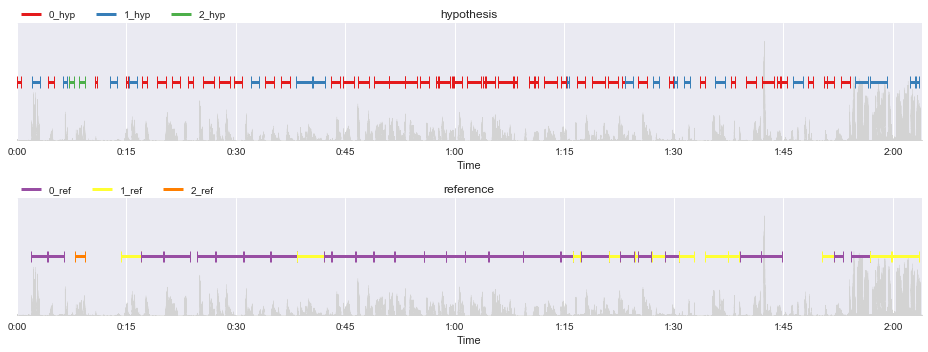

In [22]:
hypothesis = get_hypothesis(speaker_segments)
# der_value = measure_metrics(reference, hypothesis)

## PyAnnote DER and other metrics

%matplotlib inline

plot_der(hypothesis)

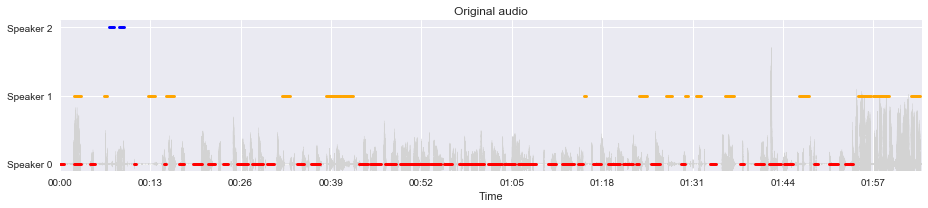

In [23]:
%matplotlib inline
plot_original_audio(speaker_segments)

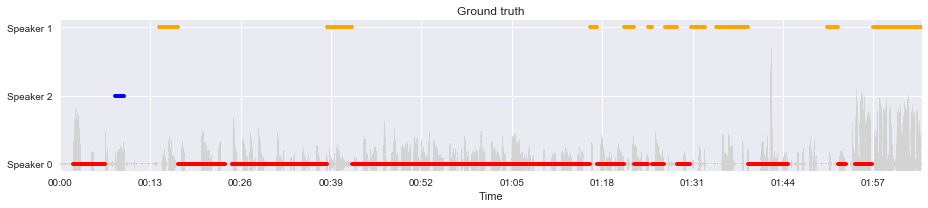

In [24]:
%matplotlib inline
plot_ground_truth()

# Diarization results: audios of unique speakers

In [25]:
for speaker_id, segs in groupby(sorted(speaker_segments, key=lambda x: x['speaker_id']), lambda x: x['speaker_id']):
    print(speaker_id)
    audio = np.concatenate([wav[s['start']:s['end']] for s in segs], axis=0)
    print(audio.shape)
    display(Audio(audio, rate=SR))

0
(1696640,)


1
(633600,)


2
(46720,)
